# Moving Average Crossover Strategy

In this project I will use both simple and exponential moving averages to determine whether to buy or sell

### Simple Moving Average

It uses the average of closing prices over a period of time. Using the formula:
$$\text{SMA} = \frac{A_1 + A_2 + \dots +A_n}{n}$$
Where:
- $A_n$ is the closing price of an asset
- $n$ is the number of periods

### Exponential Moving Average

This moving average puts more significance on the most recent values. Using hte formula:
$$\text{EMA}_\text{Today} = (\text{Value}_\text{Today} * (\frac{\text{Smoothing}}{1 + \text{Days}}))+ \text{EMA}_\text{Yesterday}*(1-(\frac{\text{Smoothing}}{1+\text{Days}}))$$
Where:
- Smoothing = 2 (this is the most common choice)

## Importing Libraries

In [37]:
import yfinance as yf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Implementing the Strategies

### Fetch data

In [38]:
# Fetch historical stock data
symbol = 'MSFT'
data = yf.download(symbol, period="2y",progress=False)
data.index = pd.to_datetime(data.index)

# Convert data to DataFrame
df = pd.DataFrame(data.copy())

# Display the first few rows of data
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2022-12-28,231.205109,234.529999,239.720001,234.169998,236.889999,17457100
2022-12-29,237.593231,241.009995,241.919998,235.649994,235.649994,19770700
2022-12-30,236.420120,239.820007,239.960007,236.660004,238.210007,21938500
2023-01-03,236.183533,239.580002,245.750000,237.399994,243.080002,25740000
2023-01-04,225.852097,229.100006,232.869995,225.960007,232.279999,50623400


### Moving Averages

Moving averages are essential in analyzing price trends over time. By smoothing out price fluctuations, they help identify whether a security is trending upward or downward. 
- **SMA** is ideal for identifying overall trends.
- **EMA** reacts more quickly to recent price changes, making it better suited for shorter-term strategies.

In [39]:
# Calculate SMA
df['50-Day SMA'] = df['Close'].rolling(window=50).mean()
df['200-Day SMA'] = df['Close'].rolling(window=200).mean()

# Calculate EMA
df['50-Day EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
df['200-Day EMA'] = df['Close'].ewm(span=200, adjust=False).mean()

### Buy and Sell Signals

A crossover strategy involves using two moving averages:
1. **Buy Signal**: When the short-term moving average (e.g., 50-day) crosses **above** the long-term moving average (e.g., 200-day). This indicates a potential upward trend.
2. **Sell Signal**: When the short-term moving average crosses **below** the long-term moving average. This indicates a potential downward trend.

In [40]:
df['Signal SMA'] = np.where(df['50-Day SMA'] > df['200-Day SMA'], 1, 0)
df['Position SMA'] = df['Signal SMA'].diff()

df['Signal EMA'] = np.where(df['50-Day EMA'] > df['200-Day EMA'], 1, 0)
df['Position EMA'] = df['Signal EMA'].diff()


### Plotting SMA

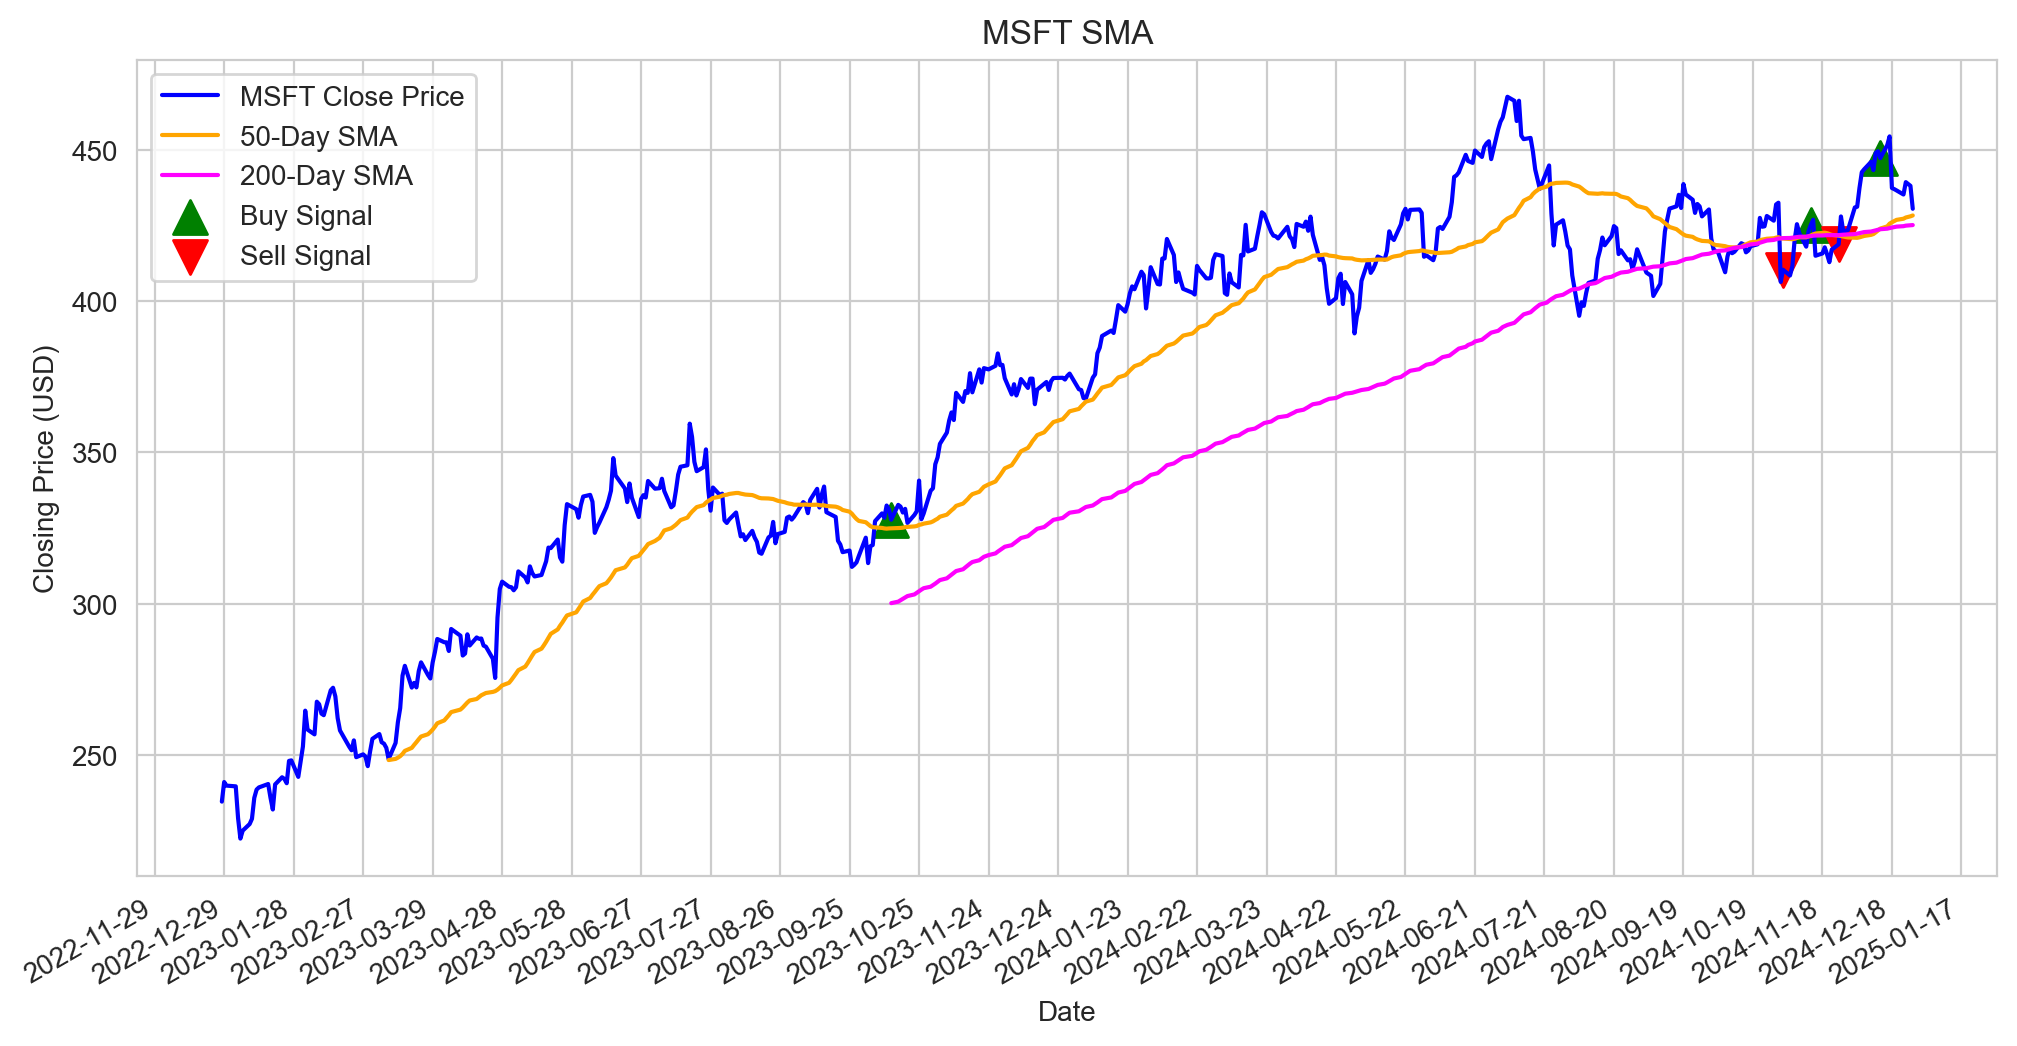

In [41]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)  # Set figure size
fig.autofmt_xdate()

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Intervals of a month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Plot with Seaborn (use index for x-axis)

close_values = df.Close.values.flatten() # Make close 1D for seaborn
sns.lineplot(x=df.index, y=close_values, label=f'{symbol} Close Price', ax=ax, color='blue')
sns.lineplot(x=df.index, y=df['50-Day SMA'], label='50-Day SMA', ax=ax, color='orange')
sns.lineplot(x=df.index, y=df['200-Day SMA'], label='200-Day SMA', ax=ax, color='magenta')

## PLot Buy Markers
buy_signals = df[df['Position SMA'] == 1]
sell_signals = df[df['Position SMA'] == -1]

ax.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150)
ax.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150)

# Add titles and labels
ax.set_title(f'{symbol} SMA')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

ax.legend(loc='best', fontsize=10)
plt.savefig('sma_strategy_plot.png', dpi=300)

plt.show()



### Plotting EMA

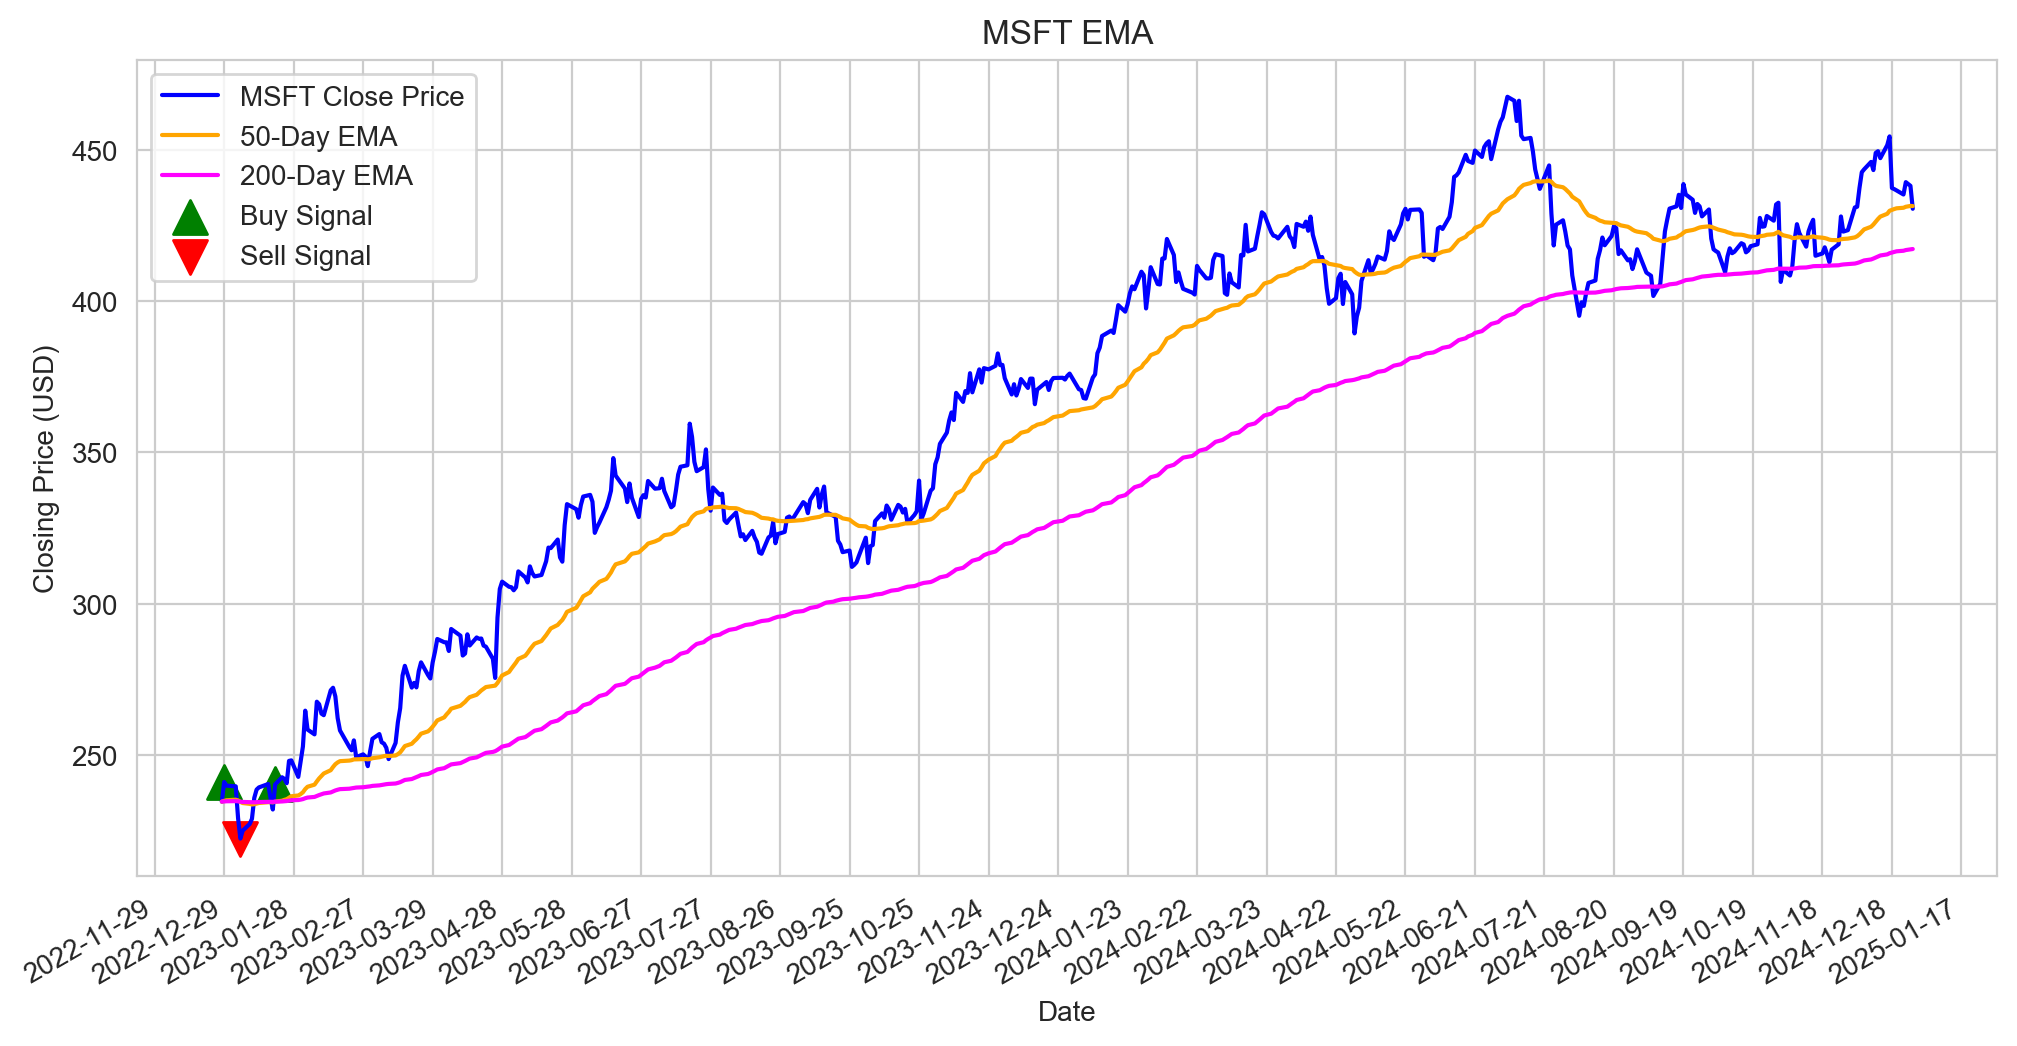

In [42]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)  # Set figure size
fig.autofmt_xdate()

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Intervals of a month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Plot with Seaborn (use index for x-axis)

close_values = df.Close.values.flatten() # Make close 1D for seaborn
sns.lineplot(x=df.index, y=close_values, label=f'{symbol} Close Price', ax=ax, color='blue')
sns.lineplot(x=df.index, y=df['50-Day EMA'], label='50-Day EMA', ax=ax, color='orange')
sns.lineplot(x=df.index, y=df['200-Day EMA'], label='200-Day EMA', ax=ax, color='magenta')

## PLot Buy Markers
buy_signals = df[df['Position EMA'] == 1]
sell_signals = df[df['Position EMA'] == -1]

ax.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150)
ax.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150)

# Add titles and labels
ax.set_title(f'{symbol} EMA')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

ax.legend(loc='best', fontsize=10)
plt.savefig('ema_strategy_plot.png', dpi=300)

plt.show()



### Strategy Performance

To evaluate the strategy's performance:
- **Cumulative Returns** track the total return over time.
- **Sharpe Ratio** measures risk-adjusted returns.


In [43]:
df['Daily Return'] = df['Close'].pct_change()
df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
print(df['Cumulative Return'].tail().to_string(index=True))


Date
2024-12-20    1.861596
2024-12-23    1.855839
2024-12-24    1.873236
2024-12-26    1.868034
2024-12-27    1.835714


In [44]:
sharpe_ratio = (df['Daily Return'].mean() / df['Daily Return'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.46
